In [1]:
import pydicom
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import morphology
from skimage.filters import threshold_otsu
from scipy import ndimage  


Bad key text.latex.unicode in file C:\Users\rajah\anaconda3\envs\temp\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 112 ('text.latex.unicode : False # use "ucs" and "inputenc" LaTeX packages for handling')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key savefig.frameon in file C:\Users\rajah\anaconda3\envs\temp\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 423 ('savefig.frameon : True')
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.3.4/matplotlibrc.template
or from the matplotlib source distribution

Bad key pgf.debug in file C:\Users\rajah\anaconda3\envs\temp\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle, line 444 ('pgf.debug           : False')
You probably need to get an updated matplotlibrc file from
h

## Utility functions

In [147]:
def remove_background(image):
    intensity_background = image.min()
    intensity_min = image_array[image_array > intensity_background].min() # After -2000, next smallest value should be zero
    
    window_image = image.copy()
    _, thresh_zero = cv2.threshold(window_image, intensity_min, intensity_min, cv2.THRESH_TOZERO)
    _, thresh_binary_inv = cv2.threshold(window_image, intensity_min, intensity_min, cv2.THRESH_BINARY_INV)
    bitwiseOr = cv2.bitwise_or(thresh_zero, thresh_binary_inv)
    
    #window_image = image.copy()
    #window_image[window_image < intensity_min] = intensity_min
    #print(window_image.min(), window_image.max())
    return bitwiseOr

In [148]:
def transform_to_hu(medical_image, image):
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope
    hu_image = slope * image.astype('float64')
    hu_image = hu_image.astype('int16')
    hu_image += np.int16(intercept)

    return np.array(hu_image, dtype=np.int16)

In [149]:
def remove_noise(image):
    
    bone_image = image.copy()
    bone_image[bone_image < 1] = 0
    # morphology.dilation creates a segmentation of the image
    # If one pixel is between the origin and the edge of a square of size
    # 5x5, the pixel belongs to the same class
    
    # We can instead use a circule using: morphology.disk(2)
    # In this case the pixel belongs to the same class if it's between the origin
    # and the radius
    
    segmentation = morphology.dilation(bone_image, np.ones((5, 5)))
    labels, label_nb = ndimage.label(segmentation)
    
    label_count = np.bincount(labels.ravel().astype(np.int))
    # The size of label_count is the number of classes/segmentations found
    
    # We don't use the first class since it's the background
    label_count[0] = 0
    
    # We create a mask with the class with more pixels
    # In this case should be the brain
    mask = labels == label_count.argmax()
    
    # Improve the brain mask
    mask = morphology.dilation(mask, np.ones((5, 5)))
    mask = ndimage.morphology.binary_fill_holes(mask)
    mask = morphology.dilation(mask, np.ones((3, 3)))
    
    # Since the the pixels in the mask are zero's and one's
    # We can multiple the original image to only keep the brain region
    masked_image = mask * bone_image
    
    return masked_image

In [2]:
def load_image(file_path):
    medical_image = pydicom.read_file(file_path)
    image = medical_image.pixel_array
    #print(image.shape)
    return medical_image, image

def plot_images(image_list, save=False):
    
    plt.figure(figsize=(20, 10))
    plt.style.use('grayscale')

    plt.subplot(141)
    plt.imshow(image_list[0])
    plt.title('Original')
    plt.axis('off')

    plt.subplot(142)
    plt.imshow(image_list[1])
    plt.title('Windowed image')
    plt.axis('off')

    plt.subplot(143)
    plt.imshow(image_list[2])
    plt.title('Skull mask')
    plt.axis('off')
    
    plt.subplot(144)
    plt.imshow(image_list[3])
    plt.title('Test mask')
    plt.axis('off')
    
#     if save:
#         mpimg.imsave(os.path.join(output_path, f'{file_path[:-4]}-original.png'), image)
#         mpimg.imsave(os.path.join(output_path, f'{file_path[:-4]}-hu_image.png'), hu_image)
#         mpimg.imsave(os.path.join(output_path, f'{file_path[:-4]}-brain_image.png'), brain_image)
#         mpimg.imsave(os.path.join(output_path, f'{file_path[:-4]}-bone_image.png'), bone_image)  

In [168]:
def process_image(image_array):
    window_image = remove_background(image_array)
    #window_image = window_image.astype('uint16')
    image_normalized = cv2.normalize(window_image, None, 0, 255, cv2.NORM_MINMAX) # change range to 0 - 65535
    _, image_normalized = cv2.threshold(image_normalized, (255 // 2), 0, cv2.THRESH_TOZERO)
    #image_normalized[image_normalized < ((2**16-1) // 2)] = 0 # Setting gray pixels to zero

    blurred = cv2.blur(image_normalized, (5, 5))
    blurred_normalized = cv2.normalize(blurred, None, 0, 255, cv2.NORM_MINMAX)
    blurred_uint8 = blurred_normalized.astype('uint8')
    thresh, skull_image = cv2.threshold(blurred_uint8, 0, 255, cv2.THRESH_BINARY | cv2.THRESH_OTSU)
    binary_opening = ndimage.binary_opening(skull_image, iterations = 1) # Remove remaining outliers
    opening_image = binary_opening * skull_image
    final_image = remove_noise(skull_image)
    final_image = binary_opening * skull_image
    final_image = remove_noise(final_image)
    
    return final_image, window_image, image_normalized

In [216]:
medical_image, image = load_image('1.dcm')

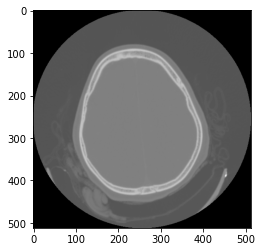

In [217]:
plt.imshow(image, cmap='gray')

In [218]:
from skimage.filters import threshold_yen

In [219]:
global_thresh = threshold_yen(image)
print(global_thresh)
binary_global = image > global_thresh

1133


In [220]:
image_thresh = image * binary_global

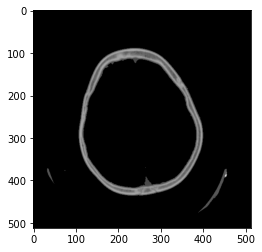

In [221]:
plt.imshow(image_thresh, cmap='gray')

In [226]:
opening = morphology.area_opening(image_thresh, area_threshold=global_thresh, connectivity=1, parent=None, tree_traverser=None)

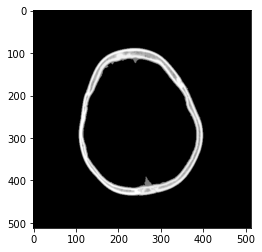

In [227]:
plt.imshow(opening, cmap='gray')

In [271]:
medical_image, image = load_image('1.dcm')

(array([[480.,   0.,   0., ...,   0.,   0.,   0.],
        [456.,   0.,   0., ...,   0.,   0.,   0.],
        [440.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [440.,   0.,   0., ...,   0.,   0.,   0.],
        [456.,   0.,   0., ...,   0.,   0.,   0.],
        [480.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([-2000. , -1390.5,  -781. ,  -171.5,   438. ,  1047.5,  1657. ,
         2266.5,  2876. ,  3485.5,  4095. ]),
 <a list of 512 BarContainer objects>)

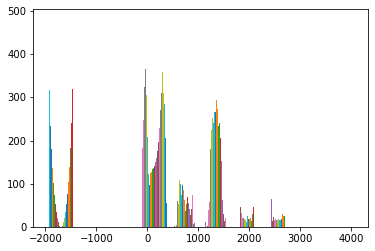

In [272]:
plt.hist(image)

In [273]:
def get_pixels_hu(medical_image, image):
    # Convert to int16 (from sometimes int16), 
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0
    
        
    intercept = medical_image.RescaleIntercept
    slope = medical_image.RescaleSlope

    image = slope * image.astype(np.float64)
    image = image.astype(np.int16)

    image += np.int16(intercept)
    
    return np.array(image, dtype=np.int16)

In [274]:
hu_image = get_pixels_hu(medical_image, image)

(array([[512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.],
        [512.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([-1024. ,  -614.5,  -205. ,   204.5,   614. ,  1023.5,  1433. ,
         1842.5,  2252. ,  2661.5,  3071. ]),
 <a list of 512 BarContainer objects>)

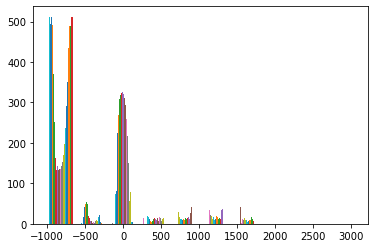

In [275]:
plt.hist(hu_image)

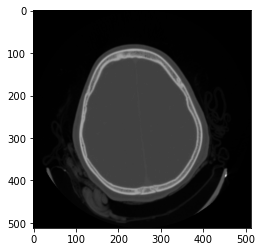

In [276]:
plt.imshow(hu_image, cmap='gray')

In [278]:
global_thresh = threshold_yen(hu_image)
print(global_thresh)
binary_global = hu_image > global_thresh

109


In [279]:
image_thresh = hu_image * binary_global

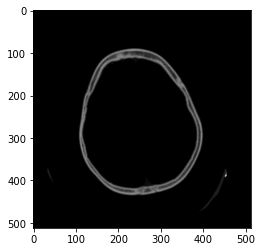

In [280]:
plt.imshow(image_thresh, cmap='gray')

In [286]:
opening = morphology.area_opening(image_thresh, area_threshold=global_thresh, connectivity=1, parent=None, tree_traverser=None)

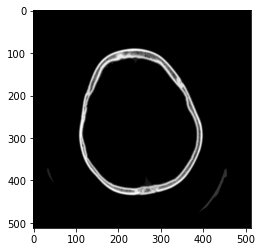

In [287]:
plt.imshow(opening, cmap='gray')

In [8]:
from skimage.filters import try_all_threshold

C:\Users\rajah\anaconda3\envs\temp\lib\site-packages\skimage\filters\thresholding.py:639: RuntimeWarning: divide by zero encountered in log
  (np.log(mean_back) - np.log(mean_fore)))


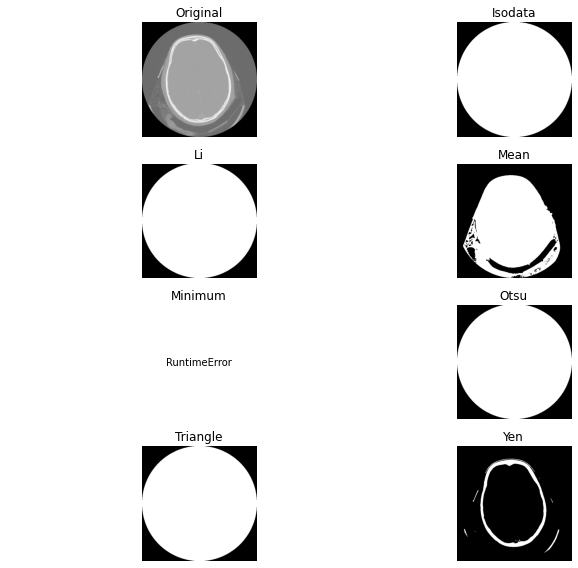

In [9]:
fig, ax = try_all_threshold(image_array, figsize=(10, 8), verbose=False)
plt.show()

In [170]:
skull_image, window_image, image_normalized = process_image(image_array)

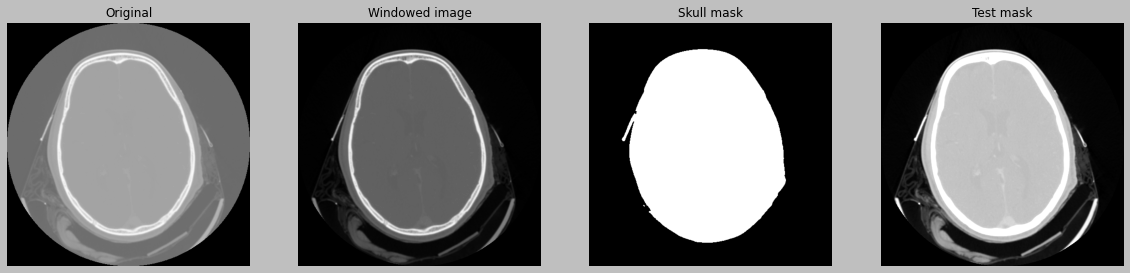

In [171]:
plot_images([image_array, window_image, skull_image, image_normalized])

In [161]:
ROOT = 'E:/skia_projects/CTBoneSegmentation/temp/data'
i = 0

for patient in os.listdir(ROOT):
    path = os.path.join(ROOT, patient)
    slices_path = os.path.join(ROOT, patient, 'slices')
    for img in glob.glob(slices_path + '/*.dcm'):
        medical_image, image_array = load_image(img)
        skull_image, window_image, image_normalized = process_image(image_array)
        cv2.imwrite(os.path.join(path, f'skull_masks/skull_{i}.png'), skull_image)
        i+=1